In [3]:
%load_ext pypath_magic
%pypath -a /home/vlad/projects/datamanagers/daily/

The pypath_magic extension is already loaded. To reload it, use:
  %reload_ext pypath_magic


UsageError: '/home/vlad/projects/datamanagers/daily' is already in the user path.


In [72]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb

# sklearn imports
import sklearn.linear_model as lm
import sklearn.ensemble as ens


from daily.datamanager import DailyDataManager
import plotter.activate
from plotter import plot
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
ddm = DailyDataManager()
df = ddm.get_data('fx_rates')
rets = df.pct_change()
rets = rets.loc[rets.isnull().sum(1) == 0]
rets = rets.fillna(0)

x = rets.drop('SEK', axis=1)
y = rets['SEK']
y_sign = (np.sign(y) == 1).astype(int)

### Random Forest

In [40]:
rf = ens.RandomForestRegressor(max_depth=4)
fit_res = rf.fit(x, y)

In [41]:
fit_res

RandomForestRegressor(max_depth=4)

In [42]:
rf.score(x, y)

0.691453417752482

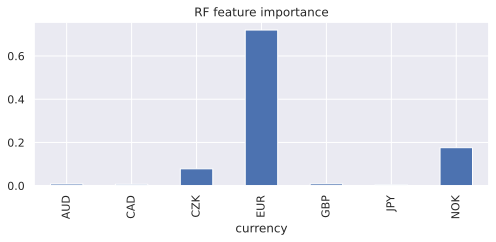

In [48]:
with plot(legend=False, title='RF feature importance') as p:
    pd.Series(fit_res.feature_importances_, index=x.columns).plot.bar(ax=p.ax())

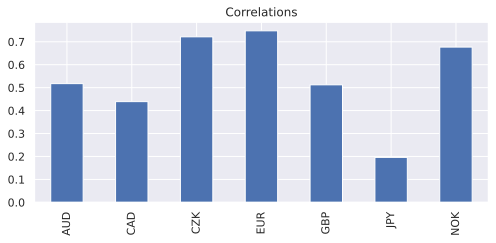

In [49]:
# individual correlations
with plot(legend=False, title='Correlations') as p:
    pd.Series({c: x[c].corr(y) for c in x.columns}).plot.bar()

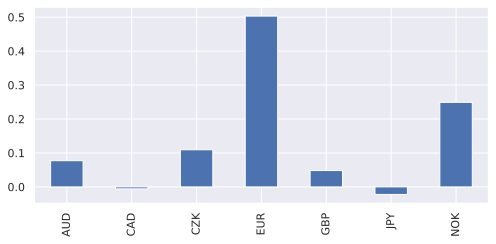

In [52]:
with plot(legend=False) as p:
    sm.OLS(y, x).fit().params.plot.bar(ax=p.ax())

### Hyperparameter cross validation

In [97]:
rf = ens.RandomForestRegressor(max_depth=4)
fit_res = rf.fit(x, y)
rf.score(x, y)

0.6923832452005891

In [98]:
from sklearn.model_selection import GridSearchCV

In [100]:
rf = ens.RandomForestRegressor()
param_grid = {'max_depth': [2, 3, 4]}
search = GridSearchCV(rf, param_grid, cv=4)
search.fit(x, y)
search.score(x, y)

0.6893680533192617

In [101]:
dir(search)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_is_fitted',
 '_check_n_features',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_validate_data',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'iid',
 'inverse_transform',
 'multimetric_',
 'n_features_in_',
 'n_jobs',
 'n_splits_',
 'param_grid',
 'pre_

In [103]:
search.best_estimator_

RandomForestRegressor(max_depth=4)

#### RF classifier

In [62]:
rf = ens.RandomForestClassifier(max_depth=4)
fit_res = rf.fit(x, y_sign)

ysp = rf.predict(x)

In [63]:
import sklearn.metrics as skm

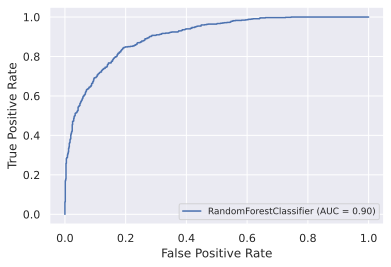

In [66]:
skm.plot_roc_curve(rf, x, y_sign);

In [67]:
ysp = rf.predict(x)

In [70]:
skm.accuracy_score(y_sign, ysp)

0.8176470588235294

## Gradient Boosting

In [90]:
gbr = xgb.XGBRegressor()
fit_res = gbr.fit(x, y)

In [91]:
gbr.score(x, y)

0.9512726705053972

In [92]:
y_pred = pd.Series(gbr.predict(x), index=y.index)

In [93]:
y_pred.corr(y)

0.9770157868088803

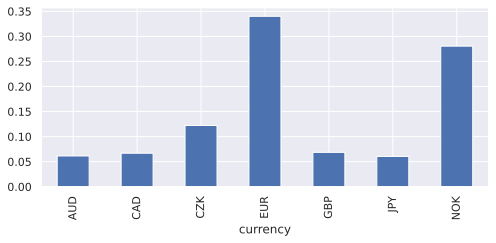

In [95]:
with plot(legend=False) as p:
    pd.Series(gbr.feature_importances_, x.columns).plot.bar(ax=p.ax())

In [82]:
from sklearn.model_selection import cross_val_score

In [83]:
gbr = xgb.XGBRegressor()
cross_val_score(gbr, x, y, cv=3)

array([0.54841657, 0.54946472, 0.6097002 ])

In [84]:
gbc = xgb.XGBClassifier()
fit_res = gbc.fit(x, y_sign)

In [88]:
cross_val_score(gbc, x, y_sign, cv=4)

array([0.7310705 , 0.75718016, 0.7539267 , 0.7382199 ])